In [7]:
# !pip install gym
# !pip install pyglet
# !pip install pygame



In [8]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import time
import pygame
import sys

In [9]:
env = gym.make("CartPole-v1")
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>

In [10]:
# 策略网络
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(PolicyNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, x):
        return self.network(x)

In [11]:
# REINFORCE算法实现
class REINFORCE:
    def __init__(self, env_name, hidden_dim=128, lr=0.001, gamma=0.99):
        self.env = gym.make(env_name)
        # 为可视化创建单独的环境
        try:
            # 尝试使用新版本的渲染方式
            self.env_render = gym.make(env_name, render_mode="human")
        except:
            # 如果失败，使用旧版本的渲染方式
            self.env_render = gym.make(env_name)

        self.gamma = gamma  # 折扣因子
        
        # 获取环境的状态空间和动作空间维度
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n
        
        # 初始化策略网络
        self.policy = PolicyNetwork(self.state_dim, self.action_dim, hidden_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        
        # 记录训练数据
        self.rewards_history = []
    
    def select_action(self, state):
        """
        根据当前状态选择动作
        """
        state = torch.FloatTensor(state)
        probs = self.policy(state)
        # 创建一个类别分布
        dist = Categorical(probs)
        # 从分布中采样一个动作
        action = dist.sample()
        # 返回动作和对应的对数概率
        return action.item(), dist.log_prob(action)
    
    def compute_returns(self, rewards):
        """
        计算每一步的rewards
        """
        returns = []
        R = 0
        
        # 从后往前计算累积回报
        for r in reversed(rewards):
            R = r + self.gamma * R
            returns.insert(0, R)
        
        # 将回报转换为张量并标准化
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)
        
        return returns

    def update_policy(self, log_probs, returns):
        """
        更新策略网络
        """
        # 计算策略损失 - 使用明确的 PyTorch 操作
        policy_losses = [-log_prob * R for log_prob, R in zip(log_probs, returns)]
        policy_loss = torch.stack(policy_losses).sum()  # 使用 stack 代替 cat
        
        # 反向传播和优化
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()
        
        return policy_loss.item()
    
    def train(self, num_episodes=1000, max_steps=1000):
        """
        训练策略网络
        """
        for episode in range(num_episodes):
            state, _ = self.env.reset()
            rewards = []
            log_probs = []
            
            # 收集一条轨迹
            for _ in range(max_steps):
                # 选择动作
                action, log_prob = self.select_action(state)
                # 执行动作
                next_state, reward, done, truncated, _ = self.env.step(action)
                
                # 存储奖励和对数概率
                rewards.append(reward)
                log_probs.append(log_prob)
                
                state = next_state
                
                # 直到 env 认为失败或者成功
                if done or truncated:
                    break
            
            # 计算回报
            returns = self.compute_returns(rewards)
            
            # 更新策略
            self.update_policy(log_probs, returns)
            
            # 记录每个episode的总奖励
            total_reward = sum(rewards)
            self.rewards_history.append(total_reward)
            
            # 打印训练进度
            if episode % 10 == 0:
                avg_reward = np.mean(self.rewards_history[-10:])
                print(f"Episode {episode}, Average Reward (last 10): {avg_reward:.2f}")
            
            # 如果平均回报足够高，可以提前终止训练
            if len(self.rewards_history) >= 100 and np.mean(self.rewards_history[-100:]) >= 195:
                print(f"Environment solved in {episode} episodes!")
                break
    
    def evaluate(self, num_episodes=10, render=False):
        """评估策略"""
        total_rewards = []
        
        for _ in range(num_episodes):
            state, _ = self.env.reset()
            episode_reward = 0
            done = False
            
            while not done:
                if render:
                    self.env.render()
                
                # 选择动作（评估模式下不需要记录log_prob）
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state)
                    probs = self.policy(state_tensor)
                    dist = Categorical(probs)
                    action = dist.sample().item()
                
                # 执行动作
                a = self.env.step(action)
                state, reward, done, truncated, _ = self.env.step(action)
                episode_reward += reward
                
                if truncated:
                    break
            
            total_rewards.append(episode_reward)
        
        avg_reward = np.mean(total_rewards)
        print(f"Average Reward over {num_episodes} episodes: {avg_reward:.2f}")
        return avg_reward
    
    def plot_rewards(self):
        """绘制奖励历史"""
        plt.figure(figsize=(10, 5))
        plt.plot(self.rewards_history)
        plt.title('Reward History')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.grid(True)
        plt.savefig('reinforce_rewards.png')
        plt.show()
    
    def save_model(self, path):
        """保存模型"""
        torch.save(self.policy.state_dict(), path)
    
    def load_model(self, path):
        """加载模型"""
        self.policy.load_state_dict(torch.load(path))
        self.policy.eval()
    
    def visualize(self, num_episodes=3, delay=0.01):
        """
        可视化训练好的模型表现
        """
        print("开始可视化...")
        
        try:
            for episode in range(num_episodes):
                state, _ = self.env_render.reset()
                episode_reward = 0
                done = False
                truncated = False
                
                while not (done or truncated):
                    # 渲染环境（新版本的gym不需要显式调用render()）
                    
                    # 稍微延迟以便观察
                    time.sleep(delay)
                    
                    # 选择动作
                    action, _ = self.select_action(state)
                    
                    # 执行动作
                    state, reward, terminated, truncated, _ = self.env_render.step(action)
                    episode_reward += reward
                    done = terminated
                
                print(f'可视化 Episode {episode+1}: 奖励 = {episode_reward}')
            
        finally:
            # 确保环境在可视化完成或出错时都能关闭
            print("清理窗口资源...")
            self.env_render.close()
            
            # 尝试关闭pygame
            try:
                print("pygame 窗口关闭成功！")
                pygame.display.quit()
            except:
                print("pygame 窗口关闭失败！")
                pass
            
            # 重新创建一个干净的环境实例以防止资源泄漏
            self.env_render = None
            
            print("可视化完成!")

Episode 0, Average Reward (last 10): 31.00
Episode 10, Average Reward (last 10): 22.10
Episode 20, Average Reward (last 10): 32.60
Episode 30, Average Reward (last 10): 36.70
Episode 40, Average Reward (last 10): 33.40
Episode 50, Average Reward (last 10): 26.60
Episode 60, Average Reward (last 10): 41.80
Episode 70, Average Reward (last 10): 70.60
Episode 80, Average Reward (last 10): 72.10
Episode 90, Average Reward (last 10): 86.10
Episode 100, Average Reward (last 10): 90.80
Episode 110, Average Reward (last 10): 92.70
Episode 120, Average Reward (last 10): 137.70
Episode 130, Average Reward (last 10): 200.30
Episode 140, Average Reward (last 10): 125.30
Episode 150, Average Reward (last 10): 86.70
Episode 160, Average Reward (last 10): 191.50
Episode 170, Average Reward (last 10): 238.80
Episode 180, Average Reward (last 10): 246.00
Episode 190, Average Reward (last 10): 266.60
Episode 200, Average Reward (last 10): 367.90
Environment solved in 200 episodes!


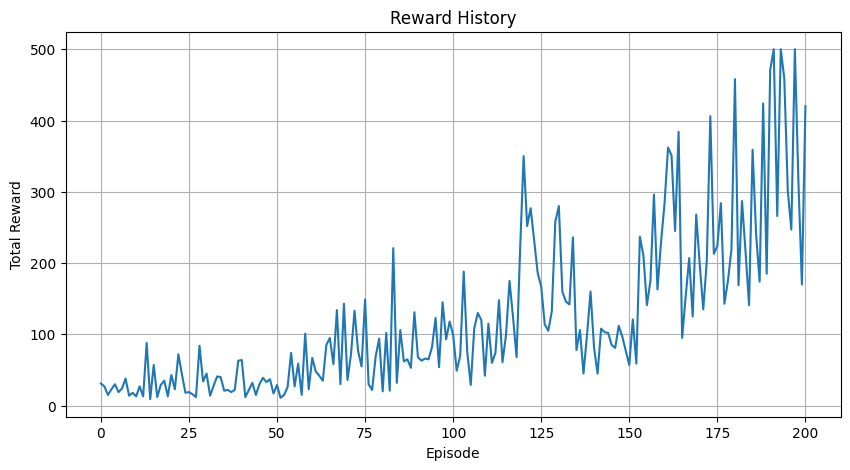

Average Reward over 10 episodes: 50.30
开始可视化...


2025-03-15 16:38:20.373 python[16997:4236587] _TIPropertyValueIsValid called with 11 on nil context!
2025-03-15 16:38:20.373 python[16997:4236587] imkxpc_setApplicationProperty:value:reply: called with incorrect property value 11, bailing.
2025-03-15 16:38:20.373 python[16997:4236587] _TIPropertyValueIsValid called with 12 on nil context!
2025-03-15 16:38:20.373 python[16997:4236587] imkxpc_setApplicationProperty:value:reply: called with incorrect property value 12, bailing.
2025-03-15 16:38:20.373 python[16997:4236587] _TIPropertyValueIsValid called with 11 on nil context!
2025-03-15 16:38:20.373 python[16997:4236587] imkxpc_setApplicationProperty:value:reply: called with incorrect property value 11, bailing.
2025-03-15 16:38:20.373 python[16997:4236587] _TIPropertyValueIsValid called with 12 on nil context!
2025-03-15 16:38:20.373 python[16997:4236587] imkxpc_setApplicationProperty:value:reply: called with incorrect property value 12, bailing.


可视化 Episode 1: 奖励 = 500.0
可视化 Episode 2: 奖励 = 270.0
可视化 Episode 3: 奖励 = 215.0
清理窗口资源...
pygame 窗口关闭成功！
可视化完成!


: 

In [ ]:
# 使用示例
if __name__ == "__main__":
    # 创建REINFORCE代理
    agent = REINFORCE(env_name="CartPole-v1", hidden_dim=128, lr=0.001, gamma=0.99)
    
    # 训练代理
    agent.train(num_episodes=10000)
    
    # 绘制奖励历史
    agent.plot_rewards()
    
    # 评估代理
    agent.evaluate(num_episodes=10, render=True)
    
    # 保存模型
    agent.save_model("reinforce_policy.pth")

    # 可视化训练后的策略
    agent.visualize(num_episodes=3)